<a href="https://colab.research.google.com/github/jhchang/Tensorflow_projects/blob/main/NLP_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Need a compute power of 7.0+ to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d05aec7f-10f6-60c7-5b25-460321a8aeac)


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
import numpy as np
from tensorflow.keras import layers

In [ ]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2023-01-15 06:59:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-15 06:59:25 (79.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data, walk_through_dir

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if os.path.exists('NLP_emotions/'):
    print('Directory already exists')
else:
    !mkdir -p NLP_emotions
    !unzip /content/drive/MyDrive/NLPEmotions.zip -d NLP_emotions

Archive:  /content/drive/MyDrive/NLPEmotions.zip
  inflating: NLP_emotions/test.txt   
  inflating: NLP_emotions/train.txt  
  inflating: NLP_emotions/val.txt    


In [ ]:
data_dir = "NLP_emotions/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['NLP_emotions/val.txt', 'NLP_emotions/train.txt', 'NLP_emotions/test.txt']

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
def get_label_and_lines(filename):
    input_lines = get_lines(filename)
    lines_and_targets = []

    for line in input_lines:
        line_data = {}
        line_split = line.split(";")
        line_data["text"] = line_split[0]
        line_data["target"] = line_split[1].replace("\n", "")
        lines_and_targets.append(line_data)

    return lines_and_targets

In [ ]:
%%time
train_samples = get_label_and_lines(data_dir + "train.txt")
val_samples = get_label_and_lines(data_dir + "val.txt") # dev is another name for validation set
test_samples = get_label_and_lines(data_dir + "test.txt")

CPU times: user 16.6 ms, sys: 7.62 ms, total: 24.2 ms
Wall time: 25.8 ms


In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,text,target
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


In [ ]:
train_df.target.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: target, dtype: int64

In [ ]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(16000, 2000, 2000)

In [ ]:

# View first 10 lines of training sentences
train_sentences[:10]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny',
 'i feel as confused about life as a teenager or as jaded as a year old man',
 'i have been with petronas for years i feel that petronas has performed well and made a huge profit',
 'i feel romantic too']

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [ ]:

# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([4, 4, 0, ..., 2, 0, 4])

In [ ]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(6, array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
       dtype=object))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.641

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 4, 2, ..., 2, 2, 2])

In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results
     

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 64.1,
 'precision': 0.7148671181119123,
 'recall': 0.641,
 'f1': 0.5476309366603793}

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

19.1663125

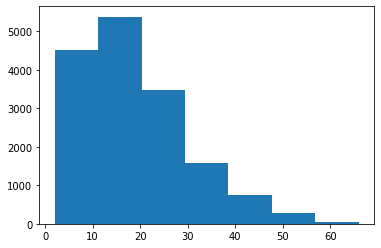

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

41

In [ ]:
max(sent_lens)

66

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(output_sequence_length=41) # desired output length of vectorized

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
i personally don t think a cavalier should be trimmed i feel it spoils the look of this breed especially when it has such a gorgeous full coat

Length of text: 28

Vectorized text:
[[    2   927   104    43    70     7 14137   121    28  8078     2     3
     13  8712     6   162    10    23  7181   291    34    13    99   181
      7   575   471  2253     0     0     0     0     0     0     0     0
      0     0     0     0     0]]


In [ ]:
vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(vocab)}"), 
print(f"Most common words in the vocabulary: {vocab[:5]}")
print(f"Least common words in the vocabulary: {vocab[-5:]}")

Number of words in vocabulary: 15214
Most common words in the vocabulary: ['', '[UNK]', 'i', 'feel', 'and']
Least common words in the vocabulary: ['aahhh', 'aac', 'aaaand', 'aaaaand', 'aaaaaaand']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': None,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 41,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

In [ ]:
token_embed = layers.Embedding(input_dim=len(vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
i personally don t think a cavalier should be trimmed i feel it spoils the look of this breed especially when it has such a gorgeous full coat

Sentence after vectorization (before embedding):
[[    2   927   104    43    70     7 14137   121    28  8078     2     3
     13  8712     6   162    10    23  7181   291    34    13    99   181
      7   575   471  2253     0     0     0     0     0     0     0     0
      0     0     0     0     0]]

Sentence after embedding:
[[[ 0.04310874 -0.02704724  0.04340434 ... -0.03581102  0.01289989
   -0.01728301]
  [ 0.02790971 -0.03510116  0.00660003 ... -0.03376085  0.00890658
   -0.00082918]
  [-0.03389638  0.04323092  0.0423282  ...  0.01507088 -0.03619323
    0.0452869 ]
  ...
  [-0.04507234  0.03719566 -0.01531184 ...  0.04792393 -0.04170827
    0.02227679]
  [-0.04507234  0.03719566 -0.01531184 ...  0.04792393 -0.04170827
    0.02227679]
  [-0.04507234  0.03719566 -0.01531184 ...  0.04792393 -0.04170827
    0

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>

In [ ]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 41)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 41, 128)          1947392   
                                                                 
 conv1d (Conv1D)             (None, 41, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 390   

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
500/500 [==============================] - 12s 5ms/step - loss: 1.1921 - accuracy: 0.5604 - val_loss: 0.6032 - val_accuracy: 0.8440
Epoch 2/3
500/500 [==============================] - 3s 5ms/step - loss: 0.3189 - accuracy: 0.9035 - val_loss: 0.3493 - val_accuracy: 0.8865
Epoch 3/3
500/500 [==============================] - 3s 5ms/step - loss: 0.1297 - accuracy: 0.9608 - val_loss: 0.3388 - val_accuracy: 0.8950


In [ ]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

63/63 [==============================] - 0s 3ms/step - loss: 0.3388 - accuracy: 0.8950


[0.338755339384079, 0.8949999809265137]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

63/63 [==============================] - 0s 2ms/step


array([[4.3537039e-03, 5.0246324e-03, 1.7712136e-04, 1.1036532e-05,
        9.9025095e-01, 1.8251929e-04],
       [1.7595864e-04, 4.4139900e-04, 1.6087528e-04, 3.8146509e-06,
        9.9917847e-01, 3.9435239e-05],
       [3.9960360e-03, 7.8672660e-04, 5.4301846e-01, 4.3604505e-01,
        1.7357295e-04, 1.5980152e-02],
       ...,
       [1.3444683e-04, 2.8825414e-05, 9.9757975e-01, 9.5662440e-04,
        1.0362365e-03, 2.6414971e-04],
       [6.7218523e-03, 3.0404783e-04, 2.2075231e-01, 7.6380283e-01,
        1.0636346e-04, 8.3126100e-03],
       [2.6460248e-03, 4.0060766e-03, 9.7495544e-01, 3.2628819e-03,
        6.6919127e-03, 8.4377527e-03]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 2, ..., 2, 3, 2])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 89.5,
 'precision': 0.8960668773661761,
 'recall': 0.895,
 'f1': 0.8946883533265092}

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
i feel much more energetic generally im sleeping better and so is my wife

Sentence after embedding:
[-0.02277522 -0.04377345  0.06470869 -0.04304386 -0.04331494  0.0516881
 -0.02457372 -0.03802719  0.03883015  0.08161023 -0.03139051  0.06074153
  0.02241157  0.05931654  0.01035249 -0.07804526 -0.02205069  0.00090049
 -0.01858154  0.05706659  0.05613578  0.02515873  0.08333541  0.0610592
 -0.02326226 -0.0442704  -0.04002713  0.03799411  0.01833928 -0.05474805] (truncated output)...

Length of sentence embedding:
512


In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 256,864,262
Trainable params: 66,438
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(len(valid_dataset)))

Epoch 1/3
500/500 [==============================] - 9s 13ms/step - loss: 1.1486 - accuracy: 0.5828 - val_loss: 0.9822 - val_accuracy: 0.6350
Epoch 2/3
500/500 [==============================] - 6s 13ms/step - loss: 0.9412 - accuracy: 0.6517 - val_loss: 0.9443 - val_accuracy: 0.6485
Epoch 3/3
500/500 [==============================] - 6s 12ms/step - loss: 0.8979 - accuracy: 0.6646 - val_loss: 0.9253 - val_accuracy: 0.6560


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

63/63 [==============================] - 1s 10ms/step - loss: 0.9253 - accuracy: 0.6560


[0.9252979159355164, 0.656000018119812]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

63/63 [==============================] - 1s 10ms/step


array([[3.5369780e-02, 1.1426521e-01, 2.5687860e-02, 1.9224685e-02,
        7.9086107e-01, 1.4591413e-02],
       [2.7458253e-03, 2.3185660e-01, 2.7820408e-01, 3.4978986e-03,
        4.4007599e-01, 4.3619607e-02],
       [3.1509348e-03, 9.5288752e-04, 2.2257662e-01, 7.6228023e-01,
        1.0326002e-02, 7.1338308e-04],
       ...,
       [1.4180297e-02, 5.0677940e-02, 6.4796412e-01, 8.3733998e-02,
        5.3232159e-02, 1.5021144e-01],
       [3.9236867e-03, 4.6523474e-03, 8.5528809e-01, 1.2957731e-01,
        4.8750783e-03, 1.6834716e-03],
       [1.8790014e-02, 3.9388981e-02, 7.2799253e-01, 1.6943038e-01,
        3.9627440e-02, 4.7707614e-03]], dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 3, ..., 2, 2, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 65.60000000000001,
 'precision': 0.6565044543275763,
 'recall': 0.656,
 'f1': 0.6509080711772137}

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'i   f e e l   m u c h   m o r e   e n e r g e t i c   g e n e r a l l y   i m   s l e e p i n g   b e t t e r   a n d   s o   i s   m y   w i f e'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

i   d i d n t   f e e l   h u m i l i a t e d


In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

96.8458125

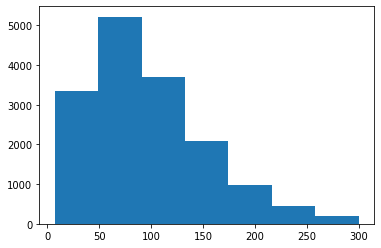

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

207

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'j', 'x', 'z', 'q']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
i   d o n t   k n o w   w h a t   c r a z y   g i r l   i   t h i n k   h e r   n a m e   w a s   k a t j a   d o e s   f o r   a   l i v i n g   i   f e e l   l i k e   s h e   s h o u l d   j u s t   d o   w h a t   i   d o   i n   r e a l   l i f e   a n d   b e   s o m e   s o r t   o f   d i s h e a r t e n e d   d i s a l l u s i o n e d   c l e r k

Length of chars: 143

Vectorized chars:
[[ 4 12  6  7  3 23  7  6 19 19 11  5  3 18 10  5 26 17 16  4 10  9  4  3
  11  4  7 23 11  2 10  7  5 14  2 19  5  8 23  5  3 24  5 12  6  2  8 13
   6 10  5  9  4 22  4  7 16  4 13  2  2  9  9  4 23  2  8 11  2  8 11  6
  15  9 12 24 15  8  3 12  6 19 11  5  3  4 12  6  4  7 10  2  5  9  9  4
  13  2  5  7 12 21  2  8  6 14  2  8  6 10  3  6 13 12  4  8 11  2  5 10
   3  2  7  2 12 12  4  8  5  9  9 15  8  4  6  7  2 12 18  9  2 10 23  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
i   d o n t   k n o w   w h a t   c r a z y   g i r l   i   t h i n k   h e r   n a m e   w a s   k a t j a   d o e s   f o r   a   l i v i n g   i   f e e l   l i k e   s h e   s h o u l d   j u s t   d o   w h a t   i   d o   i n   r e a l   l i f e   a n d   b e   s o m e   s o r t   o f   d i s h e a r t e n e d   d i s a l l u s i o n e d   c l e r k

Embedded chars (after vectorization and embedding):
[[[-0.03769059  0.03139142  0.03115015 ...  0.03774318  0.00070591
    0.02199394]
  [-0.03095314  0.00029372 -0.03538664 ... -0.04708546  0.03410678
    0.01026715]
  [-0.00535287  0.00549395 -0.00526615 ... -0.01291878 -0.04382492
    0.01092433]
  ...
  [-0.02557671 -0.02151252 -0.00078349 ...  0.01971154  0.01055641
   -0.027518  ]
  [-0.02557671 -0.02151252 -0.00078349 ...  0.01971154  0.01055641
   -0.027518  ]
  [-0.02557671 -0.02151252 -0.00078349 ...  0.01971154  0.01055641
   -0.027518  ]]]

Character embedding shape: (1

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 207)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 207, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 207, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 6

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(len(val_char_dataset)))

Epoch 1/3
500/500 [==============================] - 3s 5ms/step - loss: 1.5669 - accuracy: 0.3579 - val_loss: 1.5266 - val_accuracy: 0.3965
Epoch 2/3
500/500 [==============================] - 4s 8ms/step - loss: 1.4520 - accuracy: 0.4331 - val_loss: 1.3905 - val_accuracy: 0.4680
Epoch 3/3
500/500 [==============================] - 5s 10ms/step - loss: 1.3025 - accuracy: 0.5042 - val_loss: 1.2680 - val_accuracy: 0.5175


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

63/63 [==============================] - 0s 3ms/step - loss: 1.2680 - accuracy: 0.5175


[1.2679928541183472, 0.5174999833106995]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

63/63 [==============================] - 0s 2ms/step


array([[0.1796258 , 0.09822425, 0.05965136, 0.04584673, 0.58231944,
        0.03433241],
       [0.0503747 , 0.05355325, 0.5323744 , 0.06351077, 0.2963025 ,
        0.00388447],
       [0.08699457, 0.29378912, 0.19069931, 0.1710932 , 0.18681936,
        0.07060444],
       ...,
       [0.04925229, 0.07818184, 0.50701344, 0.04528892, 0.31588647,
        0.00437695],
       [0.07740096, 0.25692675, 0.44852933, 0.09029388, 0.11571424,
        0.0111349 ],
       [0.04386357, 0.09868936, 0.64173967, 0.08548935, 0.1147917 ,
        0.01542637]], dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 2, 1, ..., 2, 2, 2])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 51.74999999999999,
 'precision': 0.5259327949354555,
 'recall': 0.5175,
 'f1': 0.4728969148750304}

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 207)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

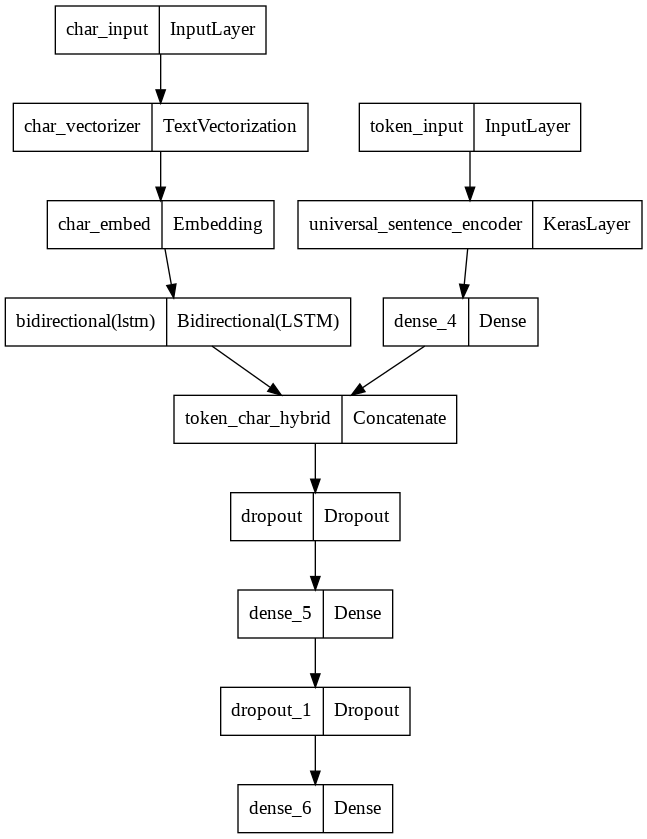

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(len(val_char_token_dataset)))

Epoch 1/3
500/500 [==============================] - 21s 31ms/step - loss: 1.2351 - accuracy: 0.5444 - val_loss: 1.0030 - val_accuracy: 0.6325
Epoch 2/3
500/500 [==============================] - 16s 32ms/step - loss: 1.0178 - accuracy: 0.6287 - val_loss: 0.9337 - val_accuracy: 0.6445
Epoch 3/3
500/500 [==============================] - 19s 38ms/step - loss: 0.9503 - accuracy: 0.6509 - val_loss: 0.9073 - val_accuracy: 0.6555


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

63/63 [==============================] - 1s 19ms/step - loss: 0.9073 - accuracy: 0.6555


[0.9073348045349121, 0.6554999947547913]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

63/63 [==============================] - 2s 18ms/step


array([[4.7107749e-02, 1.0608906e-01, 3.9119083e-02, 1.7974664e-02,
        7.6859903e-01, 2.1110492e-02],
       [3.0999724e-03, 1.3206202e-01, 2.7136022e-01, 4.4949059e-03,
        5.7249880e-01, 1.6484050e-02],
       [9.8243169e-04, 3.0813453e-04, 2.4760042e-01, 7.4614698e-01,
        4.5962222e-03, 3.6594237e-04],
       ...,
       [8.1310207e-03, 3.3940371e-02, 7.3257917e-01, 8.1169523e-02,
        2.7179824e-02, 1.1700007e-01],
       [5.0153821e-03, 4.4891723e-03, 8.1609607e-01, 1.6069618e-01,
        1.1546678e-02, 2.1565182e-03],
       [1.3421308e-02, 1.3517022e-02, 6.9349730e-01, 2.4133536e-01,
        2.6968971e-02, 1.1259949e-02]], dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds


<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([4, 4, 3, ..., 2, 2, 2])>

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 65.55,
 'precision': 0.6565008708648195,
 'recall': 0.6555,
 'f1': 0.6469136260822403}

In [ ]:
# Repeat same steps test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# This model is like model_4, but it uses our custom word embeddings instead

# Create 1D convolutional model to process sequences
token_inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(token_inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
token_outputs = layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [ ]:
model_5.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 41)          0           ['input_5[0][0]']                
 ization)                                                                                         
                                                                                                  
 token_embedding (Embedding)    (None, 41, 128)      1947392     ['text_vectorization[2][0]']     
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           [

In [ ]:
# Compile
model_5.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model on tokens and chars
model_5_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(len(val_char_token_dataset)))

Epoch 1/3
500/500 [==============================] - 15s 30ms/step - loss: 0.9056 - accuracy: 0.6654 - val_loss: 0.8804 - val_accuracy: 0.6615
Epoch 2/3
500/500 [==============================] - 15s 29ms/step - loss: 0.8637 - accuracy: 0.6796 - val_loss: 0.8554 - val_accuracy: 0.6750
Epoch 3/3
500/500 [==============================] - 16s 31ms/step - loss: 0.8305 - accuracy: 0.6932 - val_loss: 0.8463 - val_accuracy: 0.6840


In [ ]:
# Make predictions on the test dataset
test_pred_probs = model_1.predict(test_dataset,
                                  verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

63/63 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([4, 4, 4, 2, 4, 1, 0, 3, 2, 0])>

In [ ]:
# Evaluate loaded model test predictions
model_1_test_results = calculate_results(y_true=test_labels_encoded,
                                         y_pred=test_preds)
model_1_test_results

{'accuracy': 85.45,
 'precision': 0.8770684334583302,
 'recall': 0.8545,
 'f1': 0.8580875655945481}

In [ ]:
%%time
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 796 ms, sys: 62.6 ms, total: 859 ms
Wall time: 756 ms


['sadness',
 'sadness',
 'sadness',
 'joy',
 'sadness',
 'fear',
 'anger',
 'love',
 'joy',
 'anger',
 'anger',
 'fear',
 'fear',
 'joy',
 'love',
 'sadness',
 'joy',
 'sadness',
 'anger',
 'joy',
 'joy',
 'joy',
 'joy',
 'sadness',
 'sadness',
 'fear',
 'anger',
 'sadness',
 'fear',
 'anger',
 'fear',
 'anger',
 'sadness',
 'anger',
 'sadness',
 'joy',
 'surprise',
 'sadness',
 'joy',
 'joy',
 'anger',
 'sadness',
 'joy',
 'sadness',
 'joy',
 'anger',
 'joy',
 'joy',
 'fear',
 'fear',
 'sadness',
 'fear',
 'joy',
 'sadness',
 'joy',
 'anger',
 'anger',
 'joy',
 'sadness',
 'anger',
 'sadness',
 'sadness',
 'joy',
 'joy',
 'sadness',
 'fear',
 'sadness',
 'anger',
 'fear',
 'surprise',
 'joy',
 'love',
 'fear',
 'joy',
 'love',
 'anger',
 'joy',
 'sadness',
 'joy',
 'love',
 'joy',
 'anger',
 'sadness',
 'joy',
 'sadness',
 'sadness',
 'joy',
 'joy',
 'joy',
 'sadness',
 'anger',
 'fear',
 'anger',
 'fear',
 'anger',
 'anger',
 'love',
 'joy',
 'fear',
 'sadness',
 'fear',
 'fear',
 's

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,text,target,prediction,pred_prob,correct
0,im feeling rather rotten so im not very ambiti...,sadness,sadness,0.996748,True
1,im updating my blog because i feel shitty,sadness,sadness,0.998414,True
2,i never make her separate from me because i do...,sadness,sadness,0.973476,True
3,i left with my bouquet of red and yellow tulip...,joy,joy,0.957053,True
4,i was feeling a little vain when i did this one,sadness,sadness,0.997522,True
5,i cant walk into a shop anywhere where i do no...,fear,fear,0.969780,True
6,i felt anger when at the end of a telephone call,anger,anger,0.906847,True
7,i explain why i clung to a relationship with a...,joy,love,0.579521,False
8,i like to have the same breathless feeling as ...,joy,joy,0.996844,True
9,i jest i feel grumpy tired and pre menstrual w...,anger,anger,0.994792,True


In [ ]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,text,target,prediction,pred_prob,correct
1026,i have not conducted a survey but it is quite ...,sadness,fear,0.999999,False
1943,i didn t mean to get angry with you bommie i j...,sadness,anger,0.999996,False
1698,i work well with almost every client ive ever ...,sadness,anger,0.999993,False
693,i can say is that as long as you enjoy the sto...,sadness,anger,0.999939,False
1837,i hate these feelings in my heart i hate that ...,sadness,anger,0.999915,False
...,...,...,...,...,...
1732,i have not had any serious injuries or setback...,love,anger,0.913543,False
1772,i have this grave feeling it will not be back ...,joy,love,0.912729,False
98,i feel my heart is tortured by what i have done,anger,fear,0.912055,False
1569,i feel lonely who make me feel special when i ...,sadness,joy,0.907525,False


In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _,text, target, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: sadness, Pred: fear, Prob: 0.9999986886978149

Text:
i have not conducted a survey but it is quite likely that many of them feel as assaulted by onel s demons and other creators as i would have felt had the walls been covered only with eminent figures patriotic heroes and epic deeds

-----

Target: sadness, Pred: anger, Prob: 0.9999960660934448

Text:
i didn t mean to get angry with you bommie i just can t control my feelings hellip i just hated myself why i am like this the dara who can t get over with that b

-----

Target: sadness, Pred: anger, Prob: 0.9999934434890747

Text:
i work well with almost every client ive ever been in contact with because i know what it means to feel depressed angry frustrated irritated hopeless and apathetic because i feel it daily

-----

Target: sadness, Pred: anger, Prob: 0.9999394416809082

Text:
i can say is that as long as you enjoy the story it entertains you and makes you feel emotional whether it be sad happy angry disgusted or just plai